# Notebook for analysing all VR trials of one experimental group; 2-object forest

## For anaysis of *HC conditioning experiments*

## Assumes use of FlyOver version 9.7 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [407]:
__author__ = 'Hannah Haberkern, hjmhaberkern@gmail.com'

import numpy as np
import pandas as pd 
import scipy.stats as sts
import scipy.sparse as sparse

import networkx as nx
import netgraph

from os import mkdir, walk, getcwd
from os.path import sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec

#from plottingUtilities.objectPreferencePlots import 


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto'

root = Tk()
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25']


In [411]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#from operator import itemgetter
#my_indices = [0, 3, 6, 7, 10, 12, 16, 18, 20, 24] # [0, 2, 3, 7, 9, 12, 13, 14, 16, 22] 
#expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = ''#'_top10'  # chose small string, to specify dataset (e.g. top5 flies)

groupName = 'HC_control'#'G43a_proCone20m_ret'
analysisDir = '/Users/haberkernh/Desktop/transitionAnalysis/'

In [412]:
%matplotlib inline 

### Compose mutli-fly data into dataframe

In [413]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [414]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [415]:
genotype = expDir.split(sep)[-7]
starvation = expDir.split(sep)[-4]
print(genotype)
print(starvation)

HC_x_10xChrimsonR
male


In [416]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','starvation','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsPr = 0
nTrialsTr = 0
nTrialsPo = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[8] #6
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
            nTrialsTr += 1
        elif 'pre' in fileToAnalyse:
            trialtype = 'pre'
            rZones = 'off'
            nTrialsPr += 1
        else:
            trialtype = 'post'
            rZones = 'off'
            nTrialsPo += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'starvation', starvation)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlConeCyli/male/rawData/m01/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_6-7d_9h_10xChrR-HC-Ret_10bl_m01_post_out_170202203959.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_6-7d_9h_10xChrR-HC-Ret_10bl_m01_pre_out_170202194613.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_6-7d_9h_10xChrR-HC-Ret_10bl_m01_train_out_170202201815.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlConeCyli/male/rawData/m02/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_7-8d_6h_10xChrR-HC-Ret_10bl_m02_post_out_170203163015.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cm

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlConeCyli/male/rawData/m15/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_8-9d_9h_10xChrR-HC-Ret_10bl_m15_post_out_170228221040.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_8-9d_9h_10xChrR-HC-Ret_10bl_m15_pre_out_170228213913.txt', 'twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_8-9d_9h_10xChrR-HC-Ret_10bl_m15_train_out_170228215007.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/twoObjOpto/HC_x_10xChrimsonR/baseline10/controlConeCyli/male/rawData/m16/

 Analysing the following log files:

['twoObjectForestControl_1cm4cmCone_08cm3cmCyli_6cmGrid_9-10d_6h_10xChrR-HC-Ret_10bl_m16_post_out_170301191203.txt

In [417]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,reinforcement,starvation,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,m01,1.0,post,off,male,1.0,-0.000004,0.314213,0.000000,2.458721,60.622000,60.622000,35.000000,35.000000,10.0
1,m01,1.0,post,off,male,0.0,0.015708,1.806289,0.050004,1.931961,60.499089,60.499089,34.997107,34.997107,10.0
2,m01,1.0,post,off,male,1.0,0.106029,2.827235,0.100007,5.466498,60.404100,60.404100,35.014700,35.014700,10.0
3,m01,1.0,post,off,male,1.0,0.247400,3.691112,0.150011,7.088550,60.506221,60.506221,35.268251,35.268251,10.0
4,m01,1.0,post,off,male,1.0,0.431969,4.319386,0.200014,7.702125,60.650817,60.650817,35.591869,35.591869,10.0
5,m01,1.0,post,off,male,1.0,0.647953,5.104729,0.250018,8.747077,60.685981,60.685981,35.975394,35.975394,10.0
6,m01,1.0,post,off,male,1.0,0.903208,5.497401,0.300021,7.651728,60.538600,60.538600,36.387200,36.387200,10.0
7,m01,1.0,post,off,male,1.0,1.178097,5.811538,0.350025,4.690183,60.347872,60.347872,36.718886,36.718886,10.0
8,m01,1.0,post,off,male,1.0,1.468695,5.733003,0.400028,7.497454,60.170028,60.170028,36.871771,36.871771,10.0
9,m01,1.0,post,off,male,1.0,1.755365,6.204209,0.450032,11.192403,59.795337,59.795337,36.859286,36.859286,10.0


In [418]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [419]:
# Two object reinforcement test
trialName = ['pre','train','post']
gridSize = 60.0

fps = 20

In [420]:
visitRad = 15

coneCoords = [[gridSize/2, gridSize/2],
              [3*gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [3*gridSize/2, gridSize/2]]
objCoords = [coneCoords,cyliCoords]

In [421]:
# Settings for plots

objNames = ['Cone','Cylinder']
objColors = ['mediumseagreen', 'mediumorchid']
objMarker = ['^','s']
objMarkerS = [8, 6]

objBoxColors = [['lightgreen','seagreen','mediumseagreen'],
                ['palevioletred','darkmagenta','mediumorchid']] #for spec. objects
BoxColors = ['grey','slateblue','royalblue'] # for ratio between objects

trialColors = ['darkseagreen', 'darkviolet','teal']
trialMarkers = ['d','*','o']

offsets = [1.3, 1.3, 1.3]

boxalpha = 0.5
linealpha=0.5

allTrialFigSize = (12,4)
twoTrialFigSize = (16,4)

### 2D (cartesian) residency  – check if data seemed to have loaded correctly

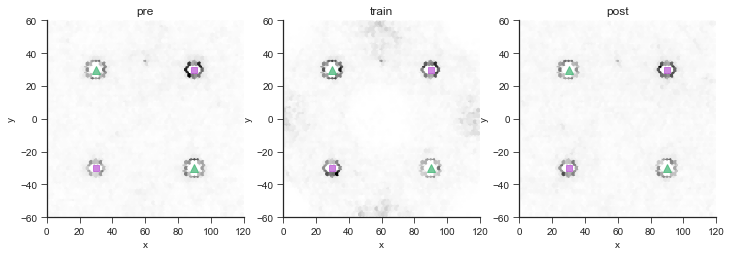

In [422]:
# plot parameter
numBins = 60

hexplotfig = plt.figure(figsize=(12,4))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
    plt.xlabel('x'); plt.ylabel('y')
    
    for obj in range(len(objNames)):
        ax.plot(objCoords[obj][0][0], objCoords[obj][0][1], marker=objMarker[obj], markersize=objMarkerS[obj], alpha=0.7, color=objColors[obj])
        ax.plot(objCoords[obj][1][0], objCoords[obj][1][1], marker=objMarker[obj], markersize=objMarkerS[obj], alpha=0.7, color=objColors[obj])

    ax.set_title(trialName[trial])
    ax.set_xlim(0,120)
    ax.set_ylim(-60,60)
    ax.set_aspect('equal')
    myAxisTheme(ax)

## Compute visits counts to be used as measure of learning

In [423]:
from plottingUtilities.objectPreferencePlots import countvisits

coneVisitFreq = np.zeros((len(flyIDs),len(trialName)))
cyliVisitFreq = np.zeros((len(flyIDs),len(trialName)))

coneVisitCount = np.zeros((len(flyIDs),len(trialName)))
cyliVisitCount = np.zeros((len(flyIDs),len(trialName)))

for fly in range(len(flyIDs)):
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,visitRad)
        
        coneVisitFreq[fly,trial] = np.sum(entriesCone)/(timeTrial[-1]/60.0)
        cyliVisitFreq[fly,trial] = np.sum(entriesCyli)/(timeTrial[-1]/60.0)
        
        coneVisitCount[fly,trial] = np.sum(entriesCone)
        cyliVisitCount[fly,trial] = np.sum(entriesCyli)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in minimum
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in minimum


In [424]:
# minimum amount of visits to any landmark in any trial to be considered in ananlysis
minVisit = 5

notEnoughVisits = np.where(np.sum((coneVisitCount[:,:] + cyliVisitCount[:,:])> minVisit, axis=1)<3)[0]
keepflies = list(np.where(np.sum((coneVisitCount[:,:] + cyliVisitCount[:,:])> minVisit, axis=1)>=3)[0])

# Sort flies to keep according to preference in post
postPref = list(np.argsort(coneVisitCount[:,2]-cyliVisitCount[:,2]))

print('Out of {} measured flies, {} made less than {} landmark visits in at least one of the three trials ({}%).\n').format(numFlies,
     len(notEnoughVisits), minVisit, 100*len(notEnoughVisits)/numFlies)
print('Flies that did not make enough visits:')
print(notEnoughVisits)
print('The remaining {} flies sorted according to their preference in the post trial (low to high)').format(len(keepflies))
print(postPref)

Out of 25 measured flies, 3 made less than 5 landmark visits in at least one of the three trials (12%).

Flies that did not make enough visits:
[13 17 19]
The remaining 22 flies sorted according to their preference in the post trial (low to high)
[21, 4, 5, 14, 9, 22, 11, 2, 8, 15, 23, 1, 20, 19, 12, 17, 18, 16, 10, 24, 3, 13, 0, 6, 7]


In [425]:
top10 = list(set(postPref[-13:]).intersection(set(keepflies)))
print('Selected {} flies:').format(len(top10))
print(top10)

Selected 10 flies:
[0, 3, 6, 7, 10, 12, 16, 18, 20, 24]


## Spatial analysis of relative heading angle distributions

In [426]:
import warnings

In [427]:
def project2triangleTile(x, y, angle, gridSize):
    """ Function to perform projection from square tile to triangle tile. 
        
        Square tile: square zone with 120 mm side length, centered on the center of 
        the square formed by 4 landmarks.
        
        Triangle tile: triangular zone defined by one cone, one cylinder and the center of 
        the square formed by 4 landmarks.
    """
    
    warnings.warn("deprecated", DeprecationWarning)
    
    slct = np.arange(0,len(x)) #~np.isnan(x)
    xt = x[slct]
    yt = y[slct]
    anglet = angle[slct]
    
    # (1) cyclic shift of big square ("miniarena")
    yt = (yt + gridSize*1.5)%(gridSize*2)
    
    # (2) cross-project top 2 squares
    leftsquare = np.logical_and(yt > gridSize, xt <= gridSize)
    rightsquare = np.logical_and(yt > gridSize, xt > gridSize)
    
    yt[leftsquare] = yt[leftsquare] - gridSize
    yt[rightsquare] = yt[rightsquare] - gridSize
    
    xt[leftsquare] = xt[leftsquare] + gridSize
    xt[rightsquare] = xt[rightsquare] - gridSize
    
    # (3) flip over the edges of the rectangle parallal to y-axis --> y unchanged, correct heading angle
    tempx = xt.copy()

    xt[tempx < gridSize/2] = abs(gridSize/2 - xt[tempx < gridSize/2]) + gridSize/2
    xt[tempx >= gridSize*1.5] = gridSize*1.5 - abs(gridSize*1.5 - xt[tempx >= gridSize*1.5])
    
    xt = xt - gridSize/2
    
    # recompute angle from flipped vector
    
    #rotate and flip, rotate back
    anglet[tempx < gridSize/2] = -(np.mod(anglet[tempx < gridSize/2] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi
    anglet[tempx >= gridSize*1.5] = -(np.mod(anglet[tempx >= gridSize*1.5] + 1.5*np.pi, 2*np.pi) - np.pi) - 0.5*np.pi

    #correct range
    angrg = anglet < -np.pi
    anglet[np.logical_and(tempx < gridSize/2, angrg)] = \
            anglet[np.logical_and(tempx < gridSize/2, angrg)] + 2*np.pi
    anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] = \
            anglet[np.logical_and(tempx >= gridSize*1.5, angrg)] + 2*np.pi
    
    
    # (4) flip lower triangle onto upper triangle (mirror along y=x diagonal)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[tempx > tempy] = tempy[tempx > tempy]
    yt[tempx > tempy] = tempx[tempx > tempy]

    #rotate and flip, rotate back
    anglet[tempx > tempy] = -(np.mod(anglet[tempx > tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(tempx > tempy, anglet < -np.pi)] + 2*np.pi
        
    
    # (5) flip upper right trianlge onto lower left triangle (mirror along y = -x + gridsize axis)
    tempx = xt.copy()
    tempy = yt.copy()
    
    xt[gridSize - tempx < tempy] = gridSize - tempy[gridSize - tempx < tempy] 
    yt[gridSize - tempx < tempy] = gridSize - tempx[gridSize - tempx < tempy]
    
    # flip parallel to x again before correcting angle
    yt = -yt + gridSize
    anglet = -anglet
    
    #rotate and flip, rotate back
    anglet[gridSize - tempx < tempy] = -(np.mod(anglet[gridSize - tempx < tempy] + 1.75*np.pi, 2*np.pi) - np.pi) - 0.75*np.pi
    
    #correct range
    anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] = \
            anglet[np.logical_and(gridSize - tempx < tempy, anglet < -np.pi)] + 2*np.pi
    
    return xt, yt, anglet

In [428]:
# Set parameters for binning
nedgesR = int(gridSize/15) + 1 #15 mm wide bins
nedgesA = int(45/15) + 1 #15 deg wide bins

# Colormap for zones
cNorm  = colors.Normalize(vmin=0, vmax=(nedgesR-1)*(nedgesA-1))
locCMap_l = plt.cm.ScalarMappable(norm=cNorm,cmap='RdPu_r')
locCMap_c = plt.cm.ScalarMappable(norm=cNorm,cmap='Greens_r')

## Bin data in triangle tile projection into zones according to LM visibility

In [429]:
# 6,30,13
rmin = 6
rmax = 30

range_closeZ = [ [0, np.pi], [rmin, rmax]]
extent_closeZ = [rmin, rmax, 0, np.pi]

range_nearZ = [ [0, np.pi], [15, 30]]
extent_nearZ = [15, 30, 0, np.pi]

histStat = 'mean'
numBins = [12,6]

dblim = 0.15

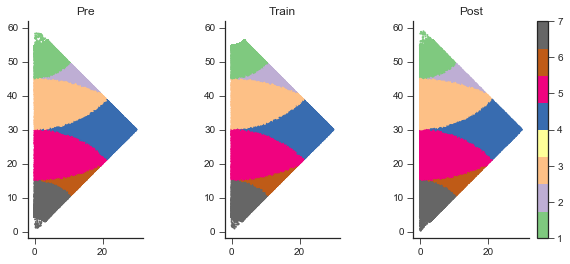

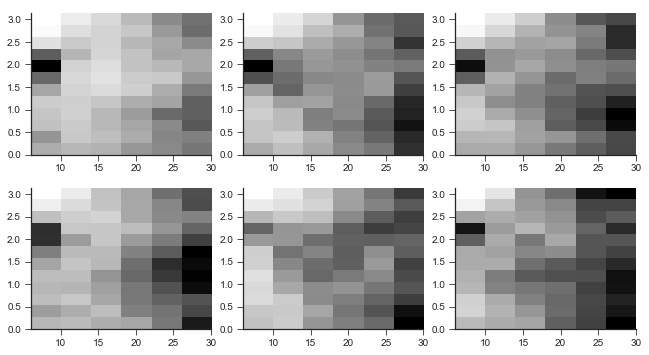

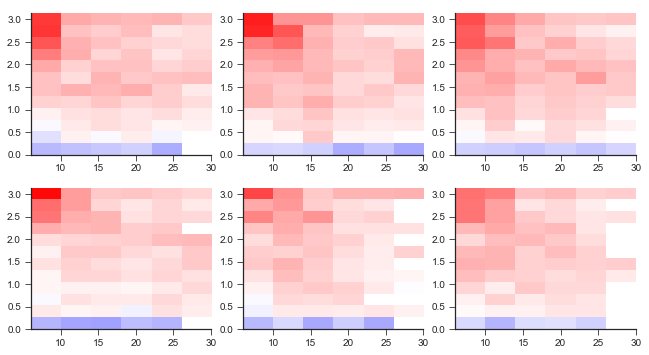

In [430]:
fig, axs = plt.subplots(1,3, figsize=(10, 4))
resfig, resplt = plt.subplots(2,3, figsize=(9, 5))
headfig, headplt = plt.subplots(2,3, figsize=(9, 5))

for tind, trial in enumerate(trialName):
    
    flyName = 'all'

    # Get data from data frame
    if (flyName == 'all'):
        querystring = '(trialtype=="' + trial + '") & (moving>0)'
    else:
        querystring = '(trialtype=="' + trial + '") & (moving>0) & (flyID == "'+flyName+'")'
    xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
    yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
    headTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_ang:keyind_ang+1].values.squeeze()
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    vRotTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_vR:keyind_vR+1].values.squeeze()

    # Project onto triangle tile
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        xt, yt, anglet = project2triangleTile(xPosTrial,yPosTrial,headTrial, gridSize)

    # Compute parameters in relation to reference landmark (relative to cone - c, relative to cylinder - l)
    #     distance to landmark vector: d_l = (-xt, -yt), d_c = (-xt, gridSize-yt)
    #     relative heading angle beta : bt (full range), bht (half range)
    #     radial distance r from landmarks: rt_l = np.hypot(xt,yt), rt_c = np.hypot(xt,yt-gridSize)
    d_l, rt_l, bt_l, bht_l, _ = relationToObject(timeTrial, xt, yt, anglet, [0,0])
    d_c, rt_c, bt_c, bht_c, _ = relationToObject(timeTrial, xt, yt, anglet, [0,gridSize])

    #     angular position vector gamma
    gt_l = -(np.arccos(xt/rt_l) - np.pi/2)*180/np.pi
    gt_c = -(np.arccos(xt/rt_c) - np.pi/2)*180/np.pi
    
    # Make masks for different visibility zones for each landmark
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c15 = rt_c <= 15
        c30 = np.logical_and(rt_c > 15, rt_c <= 30)
        c45 = np.logical_and(rt_c > 30, rt_c <= 45)
        cinv = rt_c > 45

        l15 = rt_l <= 15
        l30 = np.logical_and(rt_l > 15, rt_l <= 30)
        l45 = np.logical_and(rt_l > 30, rt_l <= 45)
        linv = rt_l > 45
    
    # Compute masks for 7 visibility zones for triangle tile
    C_visit_zone = c15
    C_noVisit_zone = np.logical_and(c30, linv)
    C_l_zone = np.logical_and(c30, l45)
    
    L_visit_zone = l15
    L_noVisit_zone = np.logical_and(l30, cinv)
    L_c_zone = np.logical_and(l30, c45)
    
    c_l_zone = np.logical_and(c45, l45)
    
    binIndex_zones =1*C_visit_zone + 2*C_noVisit_zone + 3*C_l_zone + 4*c_l_zone\
        + 5*L_c_zone + 6*L_noVisit_zone + 7*L_visit_zone
    
    cb = axs[tind].scatter(xt,yt,s=1,c=binIndex_zones, cmap='Accent', vmin=1, vmax=7)

    axs[tind].set_title(trial.capitalize())
    
    # Compute heading map for zones C_* and L_* zones
    
    binIndex_Czones = np.logical_and(binIndex_zones < 4, ~np.isnan(bht_c))
    binIndex_Lzones = np.logical_and(binIndex_zones > 4, ~np.isnan(bht_l))
    
    # residency
    H, xedg, yedg = np.histogram2d(bht_c[binIndex_Czones], rt_c[binIndex_Czones],
                                   bins=numBins, range=range_closeZ)
    map2d = resplt[0][tind].imshow(H, cmap='Greys', extent=extent_closeZ, interpolation='nearest', 
                                     origin='lower', aspect=6)
    
    H, xedg, yedg = np.histogram2d(bht_l[binIndex_Lzones], rt_l[binIndex_Lzones],
                                   bins=numBins, range=range_closeZ)
    map2d = resplt[1][tind].imshow(H, cmap='Greys', extent=extent_closeZ, interpolation='nearest', 
                                     origin='lower', aspect=6)
    
    for ax in resplt[:,tind]:
        myAxisTheme(ax)
        
        
    # Map for reorientations (= change in beta)
    dbeta_c = np.hstack((0,np.diff(bht_c)))
    dbeta_l = np.hstack((0,np.diff(bht_l)))
    
    avRot, xedg, yedg, binnum = sts.binned_statistic_2d(bht_c[binIndex_Czones], rt_c[binIndex_Czones],
                                    dbeta_c[binIndex_Czones],statistic=histStat, bins=numBins, range=range_closeZ)
    map2d = headplt[0][tind].imshow(avRot, cmap='seismic', extent=extent_closeZ, interpolation='nearest', 
                      origin='lower', aspect=6, vmin=-dblim, vmax=dblim)
    
    
    avRot, xedg, yedg, binnum = sts.binned_statistic_2d(bht_l[binIndex_Lzones], rt_l[binIndex_Lzones],
                                    dbeta_l[binIndex_Lzones],statistic=histStat, bins=numBins, range=range_closeZ)
    map2d = headplt[1][tind].imshow(avRot, cmap='seismic', extent=extent_closeZ, interpolation='nearest', 
                      origin='lower', aspect=6, vmin=-dblim, vmax=dblim)
    
    for ax in headplt[:,tind]:
        myAxisTheme(ax)

plt.colorbar(cb, ax=axs[tind])

for ax in axs:
    myAxisTheme(ax)
    ax.set_ylim(-2, gridSize+2)
    ax.set_xlim(-2, gridSize/2+2)
    ax.set_aspect('equal')
    
resfig.tight_layout()
headfig.tight_layout()

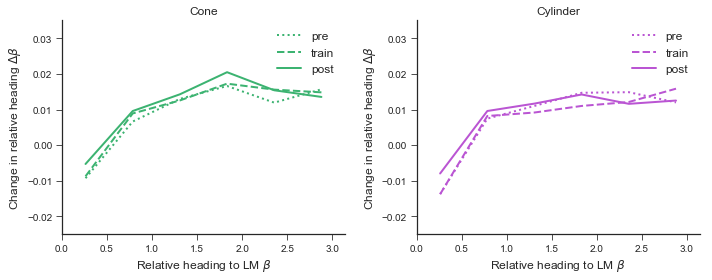

In [431]:
headfig, headplt = plt.subplots(1,2, figsize=(10, 4))
ls = [':','--','-']

for tind, trial in enumerate(trialName):
    
    flyName = 'all'

    # Get data from data frame
    if (flyName == 'all'):
        querystring = '(trialtype=="' + trial + '") & (moving>0)'
    else:
        querystring = '(trialtype=="' + trial + '") & (moving>0) & (flyID == "'+flyName+'")'
    xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
    yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
    headTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_ang:keyind_ang+1].values.squeeze()
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    vRotTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_vR:keyind_vR+1].values.squeeze()

    # Project onto triangle tile
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        xt, yt, anglet = project2triangleTile(xPosTrial,yPosTrial,headTrial, gridSize)

    # Compute parameters in relation to reference landmark (relative to cone - c, relative to cylinder - l)
    #     distance to landmark vector: d_l = (-xt, -yt), d_c = (-xt, gridSize-yt)
    #     relative heading angle beta : bt (full range), bht (half range)
    #     radial distance r from landmarks: rt_l = np.hypot(xt,yt), rt_c = np.hypot(xt,yt-gridSize)
    d_l, rt_l, bt_l, bht_l, _ = relationToObject(timeTrial, xt, yt, anglet, [0,0])
    d_c, rt_c, bt_c, bht_c, _ = relationToObject(timeTrial, xt, yt, anglet, [0,gridSize])

    #     angular position vector gamma
    gt_l = -(np.arccos(xt/rt_l) - np.pi/2)*180/np.pi
    gt_c = -(np.arccos(xt/rt_c) - np.pi/2)*180/np.pi
    
    # Make masks for different visibility zones for each landmark
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c15 = rt_c <= 15
        c30 = np.logical_and(rt_c > 15, rt_c <= 30)
        c45 = np.logical_and(rt_c > 30, rt_c <= 45)
        cinv = rt_c > 45

        l15 = rt_l <= 15
        l30 = np.logical_and(rt_l > 15, rt_l <= 30)
        l45 = np.logical_and(rt_l > 30, rt_l <= 45)
        linv = rt_l > 45
    
    # Compute masks for 7 visibility zones for triangle tile
    C_visit_zone = c15
    C_noVisit_zone = np.logical_and(c30, linv)
    C_l_zone = np.logical_and(c30, l45)
    
    L_visit_zone = l15
    L_noVisit_zone = np.logical_and(l30, cinv)
    L_c_zone = np.logical_and(l30, c45)
    
    c_l_zone = np.logical_and(c45, l45)
    
    binIndex_zones =1*C_visit_zone + 2*C_noVisit_zone + 3*C_l_zone + 4*c_l_zone\
        + 5*L_c_zone + 6*L_noVisit_zone + 7*L_visit_zone
    
    # Map for reorientations (= change in beta)
    dbeta_c = np.hstack((0,np.diff(bht_c)))
    dbeta_l = np.hstack((0,np.diff(bht_l)))
    
    # Compute heading map for zones C_* and L_* zones
    #binIndex_Czones = np.logical_and(binIndex_zones < 4, ~np.isnan(dbeta_c))
    #binIndex_Lzones = np.logical_and(binIndex_zones > 4, ~np.isnan(dbeta_l))
    
    binIndex_Czones = np.logical_and(~np.isnan(dbeta_c), np.logical_or(binIndex_zones == 2, binIndex_zones == 3))
    binIndex_Lzones = np.logical_and(~np.isnan(dbeta_l), np.logical_or(binIndex_zones == 6, binIndex_zones == 5))
    
    # plot
    avDB, xedg, binnum = sts.binned_statistic(bht_c[binIndex_Czones], dbeta_c[binIndex_Czones], 
                                              statistic=histStat, bins=numBins[0]/2, range=range_nearZ[0])
    headplt[0].plot(xedg[:-1]+np.diff(xedg)/2, avDB, linewidth=2, color=objColors[0], linestyle=ls[tind])
    
    avDB, xedg, binnum = sts.binned_statistic(bht_l[binIndex_Lzones], dbeta_l[binIndex_Lzones], 
                                              statistic=histStat, bins=numBins[0]/2, range=range_nearZ[0])
    headplt[1].plot(xedg[:-1]+np.diff(xedg)/2, avDB, linewidth=2, color=objColors[1], linestyle=ls[tind])
    
    
for i,ax in enumerate(headplt):
    myAxisTheme(ax)
    ax.legend(trialName, fontsize=12)
    ax.set_title(objNames[i],fontsize=12)
    ax.set_xlim(0, np.pi)
    ax.set_ylim(-0.025, 0.035)
    ax.set_xlabel(r'Relative heading to LM $\beta$', fontsize=12)
    ax.set_ylabel(r'Change in relative heading $\Delta \beta$',fontsize=12)

headfig.tight_layout()

### Transitions between visibility zones

In [432]:
transSpaces = []
transCounts = []

dt = int(1*fps)

for tind, trial in enumerate(trialName):

    flyName = 'all'

    # Get data from data frame
    if (flyName == 'all'):
        querystring = '(trialtype=="' + trial + '") & (moving>0)'
    else:
        querystring = '(trialtype=="' + trial + '") & (moving>0) & (flyID == "'+flyName+'")'

    xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
    yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    headTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_ang:keyind_ang+1].values.squeeze()

    # Project onto triangle tile
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        xt, yt, anglet = project2triangleTile(xPosTrial,yPosTrial,headTrial, gridSize)

    # Compute parameters in relation to reference landmark (relative to cone - c, relative to cylinder - l)
    #     distance to landmark vector: d_l = (-xt, -yt), d_c = (-xt, gridSize-yt)
    #     relative heading angle beta : bt (full range), bht (half range)
    #     radial distance r from landmarks: rt_l = np.hypot(xt,yt), rt_c = np.hypot(xt,yt-gridSize)
    d_l, rt_l, bt_l, bht_l, _ = relationToObject(timeTrial, xt, yt, anglet, [0,0])
    d_c, rt_c, bt_c, bht_c, _ = relationToObject(timeTrial, xt, yt, anglet, [0,gridSize])

    #     angular position vector gamma
    gt_l = -(np.arccos(xt/rt_l) - np.pi/2)*180/np.pi
    gt_c = -(np.arccos(xt/rt_c) - np.pi/2)*180/np.pi

    # Make masks for different visibility zones for each landmark
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c15 = rt_c <= 15
        c30 = np.logical_and(rt_c > 15, rt_c <= 30)
        c45 = np.logical_and(rt_c > 30, rt_c <= 45)
        cinv = rt_c > 45

        l15 = rt_l <= 15
        l30 = np.logical_and(rt_l > 15, rt_l <= 30)
        l45 = np.logical_and(rt_l > 30, rt_l <= 45)
        linv = rt_l > 45

    # Compute masks for 7 visibility zones for triangle tile
    C_visit_zone = c15
    C_noVisit_zone = np.logical_and(c30, linv)
    C_l_zone = np.logical_and(c30, l45)

    L_visit_zone = l15
    L_noVisit_zone = np.logical_and(l30, cinv)
    L_c_zone = np.logical_and(l30, c45)

    c_l_zone = np.logical_and(c45, l45)

    binIndex_zones =1*C_visit_zone + 2*C_noVisit_zone + 3*C_l_zone + 4*c_l_zone\
        + 5*L_c_zone + 6*L_noVisit_zone + 7*L_visit_zone

    
    transitions = zip(binIndex_zones[:-dt], binIndex_zones[dt:])
    transSpace = list(set(transitions))
    transCount = np.zeros(len(transSpace))
    for i, trans in enumerate(transSpace):
        count = transitions.count(trans)
        transCount[i] = count
        
    transSpaces.append(transSpace)
    transCounts.append(transCount)

In [433]:
nodeNames = set([n1 for n1, n2 in transSpaces[0]] + [n2 for n1, n2 in transSpaces[0]])
nodeNames

{0, 1, 2, 3, 4, 5, 6, 7}

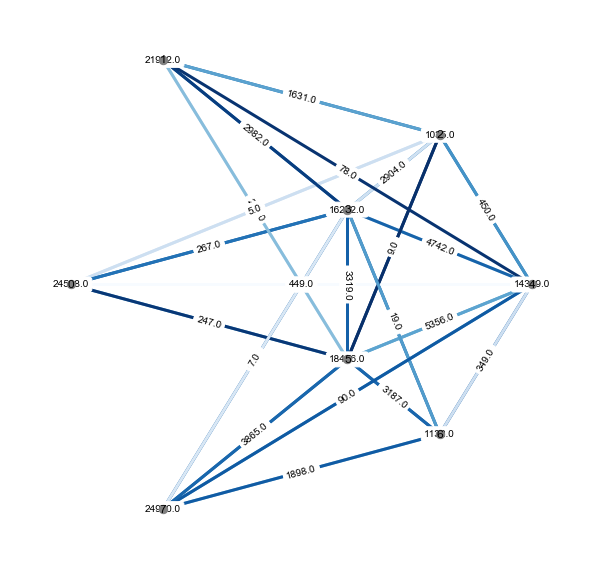

In [434]:
G=nx.DiGraph(directed=True)

# 1) nodes
#add nodes
G.add_nodes_from(nodeNames)

# positions for all nodes
pos=nx.circular_layout(G)
node_positions = {0 : (0, 4), 1 : (0.5, 7), 2 : (2, 6), 3 : (1.5, 5), 4 : (2.5, 4), 5 : (1.5, 3), 6 : (2, 2), 7 : (0.5, 1)}

pos = node_positions

# 2) edges

for i, edge in enumerate(transSpace):
    G.add_edge(edge[0], edge[1], weight=transCount[i] )

edgeLabs = dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
# 3) draw graph

_,weights = zip(*nx.get_edge_attributes(G,'weight').items())

fig, ax = plt.subplots(1,1,figsize=(10,10))

nx.draw_networkx(G, pos, node_color='grey', node_size=70,ax=ax, arrows=False)

edges = nx.draw_networkx_edges(G, pos, node_size=10,arrows=False,
                               edge_color=np.log(weights)/max(np.log(weights)),
                               edge_cmap=plt.cm.Blues, width=3)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeLabs)


ax.axis('off');


[[11042     0     1   157   226    35     0     0]
 [    0 28310  1385  3403   119   278     0     0]
 [    0  1987  1361  2670   336     3     0     0]
 [  134  3188  3262 17022  4834  2843    12     5]
 [  208     7   326  4743 19385  5576   334    19]
 [   77     3    22  3164  5311 20372  3466  3397]
 [    0     0     0     5   321  2945  1300  2080]
 [    0     0     0   122    69  3771  1539 29103]]
[[11380     0     0    35    96   171     2     0]
 [    0 21383  1336  2944    72   190     5     0]
 [    0  1417   723  2596   243    27     0     0]
 [   86  3062  2798 14006  3421  3393    46    29]
 [  135    38   125  3749 27102  3563   100    10]
 [   82    30    21  3445  3560 16926  3427  3190]
 [    0     0     3    19   245  3291  1168  1781]
 [    1     0     0    64    70  3116  1759 21962]]
[[24588     0     4   267   449   247     0     0]
 [    0 21902  1631  3104    78   232     0     0]
 [    5  2059  1035  2904   450     9     0     0]
 [  281  2982  3412 16272  47

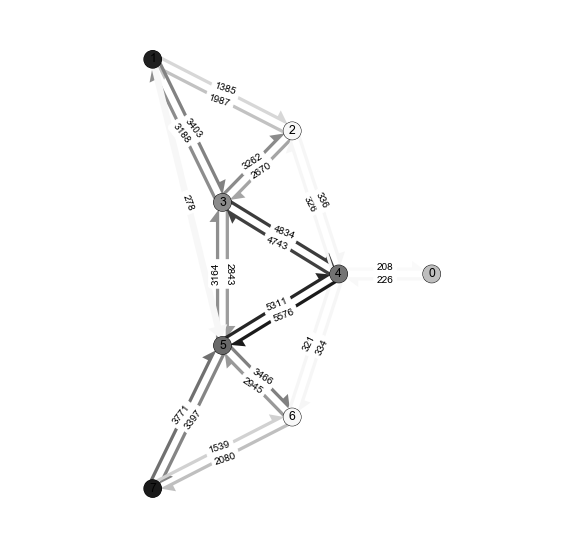

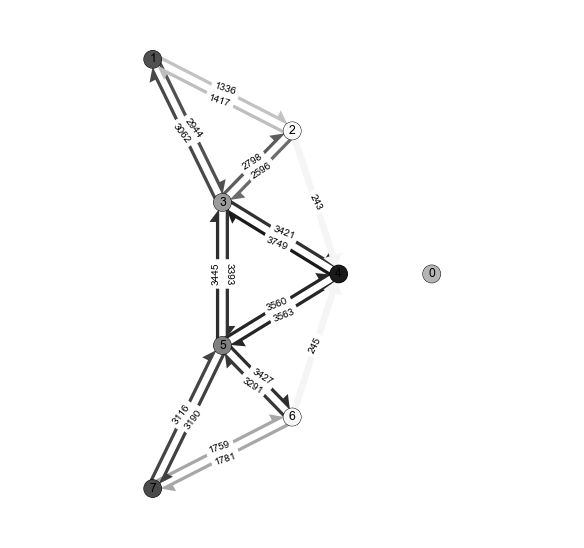

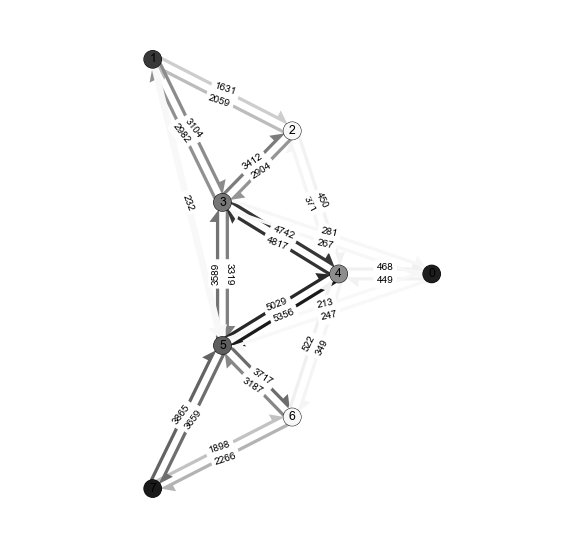

In [435]:
for tind, trial in enumerate(trialName):
    
    transSpace = transSpaces[tind]
    transCount = transCounts[tind]
    
    nodeNames = set([n1 for n1, n2 in transSpace] + [n2 for n1, n2 in transSpace])
    
    shape = (max(nodeNames)+1, max(nodeNames)+1)
    edgeArray = np.asarray(transSpace)

    coo = sparse.coo_matrix((transCount, (edgeArray[:, 0], edgeArray[:, 1])), shape=shape,
                            dtype=edgeArray.dtype)

    connectivityMatrix = np.asarray(coo.todense())
    print(connectivityMatrix)


    fig, ax = plt.subplots(1,1, figsize=(10,10))

    countCutoff = 200  #50 for all, 5 for single fly

    graph = connectivityMatrix/1.

    graphOffDig = graph.copy()

    node_count = np.zeros(shape[0])
    for i in range(shape[0]):
        node_count[i] = graph[i,i]
        graphOffDig[i,i] = 0

    for i in range(shape[0]):
        for j in range(shape[0]):
            if graphOffDig[i,j] <= countCutoff:
                graphOffDig[i,j] = 0

    normGraph = graphOffDig/np.max(graphOffDig)

    sc = 1.3
    node_positions = {0 : (3.5, 4/sc), 1 : (0.5, 7/sc), 2 : (2, 6/sc), 3 : (1.25, 5/sc), \
                      4 : (2.5, 4/sc), 5 : (1.25, 3/sc), 6 : (2, 2/sc), 7 : (0.5, 1/sc)}

    node_names = {0 : '0', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6', 7 : '7'}

    #mylabels = dict([((edgeArray[i,0],edgeArray[i,1],),int(transCount[i])) for i in range(len(edgeArray))])
    mylabels = dict([((edgeArray[transCount > countCutoff,:][i,0],
                       edgeArray[transCount > countCutoff,:][i,1],),int(transCount[transCount > countCutoff][i])) 
                     for i in range(len(edgeArray[transCount > countCutoff,:]))])
    # generate node color map
    cNorm  = colors.Normalize(vmin=0, vmax=np.max(node_count))
    nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Reds')

    # plot
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        netgraph.draw(normGraph,node_positions, node_size=7, ax=ax, node_labels=node_names,\
                      edge_width=7,edge_cmap='RdGy',edge_labels=mylabels)
    ax.set_ylim(0.5/sc,7.5/sc)
    ax.set_xlim(-1,5)
    ax.axis('off')
    
    # color nodes according to count
    # generate node color map
    numNodes = len(node_names)
    cNorm  = colors.Normalize(vmin=-np.max(abs(node_count)), vmax=np.max(abs(node_count)))
    nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='RdGy')

    i = 0
    for key, values in node_positions.items():
        node_to_artist = netgraph.draw_nodes({key : values}, node_color=nodeCMap.to_rgba(node_count[i]),\
                                             ax=ax, node_size=10)
        i = i+1
        
    fig.savefig(analysisDir + groupName +'_cutoff'+str(countCutoff)+'_dt'+str(dt)+'_'+ trial+'.pdf', format='pdf')

In [436]:
node_count = np.zeros((len(trialName),shape[0]))
for tind, trial in enumerate(trialName):
    
    transSpace = transSpaces[tind]
    transCount = transCounts[tind]
    
    #nodeNames = set([n1 for n1, n2 in transSpace] + [n2 for n1, n2 in transSpace])
    shape = (max(nodeNames)+1, max(nodeNames)+1)
    edgeArray = np.asarray(transSpace)
    coo = sparse.coo_matrix((transCount, (edgeArray[:, 0], edgeArray[:, 1])), shape=shape,
                            dtype=edgeArray.dtype)

    connectivityMatrix = np.asarray(coo.todense())

    for i in range(shape[0]):
        node_count[tind,i] = connectivityMatrix[i,i]

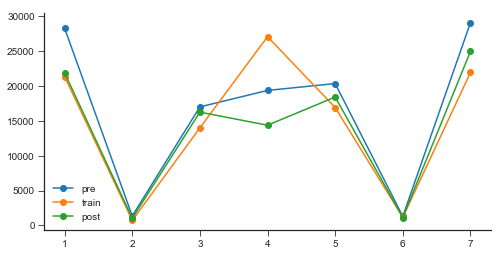

In [437]:
nodeNames = set([n1 for n1, n2 in transSpaces[0]] + [n2 for n1, n2 in transSpaces[0]])

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(list(nodeNames)[1:],node_count[:,1:].T,'-o')
ax.legend(trialName)
myAxisTheme(ax)

fig.savefig(analysisDir + groupName +'_nodeCountPerTrial_dt'+str(dt)+'.pdf', format='pdf')

In [438]:
connectivityMatrixes = np.zeros((len(trialName),len(nodeNames),len(nodeNames)))
edgeArrays = []
for tind, trial in enumerate(trialName):
    
    transSpace = transSpaces[tind]
    transCount = transCounts[tind]
    
    #nodeNames = set([n1 for n1, n2 in transSpace] + [n2 for n1, n2 in transSpace])
    
    shape = (max(nodeNames)+1, max(nodeNames)+1)
    edgeArray = np.asarray(transSpace)

    coo = sparse.coo_matrix((transCount, (edgeArray[:, 0], edgeArray[:, 1])), shape=shape,
                            dtype=edgeArray.dtype)

    connectivityMatrix = np.asarray(coo.todense())
    connectivityMatrixes[tind,:,:] = connectivityMatrix
    edgeArrays.append(edgeArray)

[[   0.    0.    0.  110.  223.  212.    0.    0.]
 [   0.    0.  246. -299.    0.    0.    0.    0.]
 [   0.   72.    0.  234.  114.    0.    0.    0.]
 [ 147. -206.  150.    0.  -92.  476.    0.    0.]
 [ 260.    0.    0.   74.    0. -220.    0.    0.]
 [ 136.    0.    0.  425. -282.    0.  251.  262.]
 [   0.    0.    0.    0.  201.  242.    0.  186.]
 [   0.    0.    0.  -59.    0.   94.  359.    0.]]


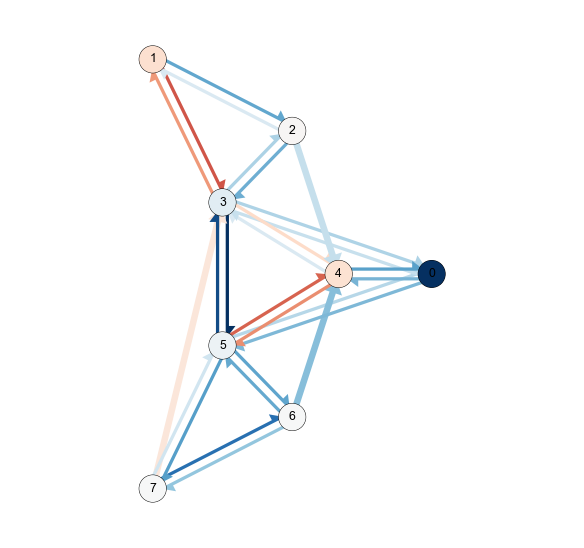

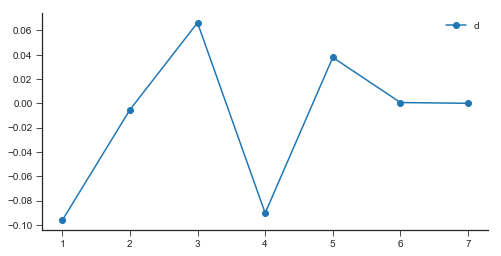

In [439]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

m1 = connectivityMatrixes[2,:,:].copy()
m2 = connectivityMatrixes[0,:,:].copy()

node_count = np.zeros(shape[0])
for i in range(shape[0]):
    node_count[i] = m1[i,i]/np.max(connectivityMatrixes[2,:,:])-m2[i,i]/np.max(connectivityMatrixes[0,:,:])
    
for i in range(shape[0]):
    m1[i,i] = 0
    m2[i,i] = 0
    
graphOffDig =  m1-m2#m1/np.max(m1) - m2/np.max(m2)

countCutoff = 50#5

for i in range(shape[0]):
    for j in range(shape[0]):
        if abs(graphOffDig[i,j]) <= countCutoff:
            graphOffDig[i,j] = 0

sc = 1.3
node_positions = {0 : (3.5, 4/sc), 1 : (0.5, 7/sc), 2 : (2, 6/sc), 3 : (1.25, 5/sc), \
                  4 : (2.5, 4/sc), 5 : (1.25, 3/sc), 6 : (2, 2/sc), 7 : (0.5, 1/sc)}

node_names = {0 : '0', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6', 7 : '7'}

#mylabels = dict([((edgeArray[i,0],edgeArray[i,1],),int(transCount[i])) for i in range(len(edgeArray))])

# generate node color map
cNorm  = colors.Normalize(vmin=0, vmax=np.max(node_count))
nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Reds')

# plot
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    netgraph.draw(graphOffDig,node_positions, node_size=7, ax=ax, node_labels=node_names,\
                  edge_width=7,edge_cmap='RdBu')#,edge_labels=mylabels)
ax.set_ylim(0.5/sc,7.5/sc)
ax.set_xlim(-1,5)
ax.axis('off');

# color nodes according to count
# generate node color map
numNodes = len(node_names)
cNorm  = colors.Normalize(vmin=-np.max(abs(node_count)), vmax=np.max(abs(node_count)))
nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='RdBu')

i = 0
for key, values in node_positions.items():
    node_to_artist = netgraph.draw_nodes({key : values}, node_color=nodeCMap.to_rgba(node_count[i]),\
                                         ax=ax, node_size=15)
    i = i+1
    
fig.savefig(analysisDir + groupName +'_prePostDiff_cutoff'+str(countCutoff)+'_dt'+str(dt)+'.pdf', format='pdf')

print(graphOffDig.astype('float'))

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(list(nodeNames)[1:],node_count.T[1:],'-o')
ax.legend('diff')
myAxisTheme(ax)
fig.savefig(analysisDir + groupName +'_prePostDiffStatecount_dt'+str(dt)+'.pdf', format='pdf')

In [440]:

for tind, trial in enumerate(trialName):
    
    transSpace = transSpaces[tind]
    transCount = transCounts[tind]

    nodeNames = set([n1 for n1, n2 in transSpace] + [n2 for n1, n2 in transSpace])

    shape = (max(nodeNames)+1, max(nodeNames)+1)
    edgeArray = np.asarray(transSpace)

    coo = sparse.coo_matrix((transCount, (edgeArray[:, 0], edgeArray[:, 1])), shape=shape,
                            dtype=edgeArray.dtype)

    connectivityMatrix = np.asarray(coo.todense())
    print(connectivityMatrix)


[[11042     0     1   157   226    35     0     0]
 [    0 28310  1385  3403   119   278     0     0]
 [    0  1987  1361  2670   336     3     0     0]
 [  134  3188  3262 17022  4834  2843    12     5]
 [  208     7   326  4743 19385  5576   334    19]
 [   77     3    22  3164  5311 20372  3466  3397]
 [    0     0     0     5   321  2945  1300  2080]
 [    0     0     0   122    69  3771  1539 29103]]
[[11380     0     0    35    96   171     2     0]
 [    0 21383  1336  2944    72   190     5     0]
 [    0  1417   723  2596   243    27     0     0]
 [   86  3062  2798 14006  3421  3393    46    29]
 [  135    38   125  3749 27102  3563   100    10]
 [   82    30    21  3445  3560 16926  3427  3190]
 [    0     0     3    19   245  3291  1168  1781]
 [    1     0     0    64    70  3116  1759 21962]]
[[24588     0     4   267   449   247     0     0]
 [    0 21902  1631  3104    78   232     0     0]
 [    5  2059  1035  2904   450     9     0     0]
 [  281  2982  3412 16272  47

In [466]:
markovMatrix = connectivityMatrix.astype('float')/np.sum(connectivityMatrix, axis=0)
markovMatrix

array([[  9.62160047e-01,   0.00000000e+00,   6.19003405e-04,
          8.60624033e-03,   1.74375704e-02,   7.12822141e-03,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   8.12780643e-01,   2.52398638e-01,
          1.00051573e-01,   3.02924385e-03,   6.69533347e-03,
          0.00000000e+00,   0.00000000e+00],
       [  1.95656427e-04,   7.64092478e-02,   1.60167131e-01,
          9.36049510e-02,   1.74764069e-02,   2.59732764e-04,
          0.00000000e+00,   0.00000000e+00],
       [  1.09958912e-02,   1.10661669e-01,   5.28009904e-01,
          5.24497163e-01,   1.84162492e-01,   9.57836715e-02,
          2.67041462e-03,   2.26346763e-04],
       [  1.83134416e-02,   3.71098824e-05,   5.74125658e-02,
          1.55266890e-01,   5.58817818e-01,   1.54569854e-01,
          4.90513001e-02,   1.29341008e-04],
       [  8.33496380e-03,   1.11329647e-04,   1.39275766e-03,
          1.15684631e-01,   1.95308556e-01,   5.32048137e-01,
          5.22417428e-01,   1.1

In [481]:
inistate = np.zeros(numNodes)
inistate[4] = 1
inistate

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [494]:
k=10
markov_k = np.linalg.matrix_power(markovMatrix, k)

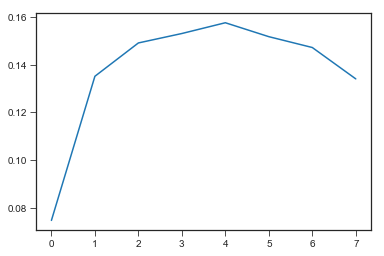

In [495]:
plt.plot(np.matmul(inistate, markov_k))

### Condition on heading

In [403]:
transSpaces = []
transCounts = []

dt = int(1*fps)

angleMask = 'alphaNeg'

for tind, trial in enumerate(trialName):

    flyName = 'all'

    # Get data from data frame
    if (flyName == 'all'):
        querystring = '(trialtype=="' + trial + '") & (moving>0)'
    else:
        querystring = '(trialtype=="' + trial + '") & (moving>0) & (flyID == "'+flyName+'")'

    xPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1].values.squeeze()
    yPosTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_yPos:keyind_yPos+1].values.squeeze()
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    headTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_ang:keyind_ang+1].values.squeeze()

    # Project onto triangle tile
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        xt, yt, anglet = project2triangleTile(xPosTrial,yPosTrial,headTrial, gridSize)

    # Compute parameters in relation to reference landmark (relative to cone - c, relative to cylinder - l)
    #     distance to landmark vector: d_l = (-xt, -yt), d_c = (-xt, gridSize-yt)
    #     relative heading angle beta : bt (full range), bht (half range)
    #     radial distance r from landmarks: rt_l = np.hypot(xt,yt), rt_c = np.hypot(xt,yt-gridSize)
    d_l, rt_l, bt_l, bht_l, _ = relationToObject(timeTrial, xt, yt, anglet, [0,0])
    d_c, rt_c, bt_c, bht_c, _ = relationToObject(timeTrial, xt, yt, anglet, [0,gridSize])

    #     angular position vector gamma
    gt_l = -(np.arccos(xt/rt_l) - np.pi/2)*180/np.pi
    gt_c = -(np.arccos(xt/rt_c) - np.pi/2)*180/np.pi

    # Make masks for different visibility zones for each landmark
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c15 = rt_c <= 15
        c30 = np.logical_and(rt_c > 15, rt_c <= 30)
        c45 = np.logical_and(rt_c > 30, rt_c <= 45)
        cinv = rt_c > 45

        l15 = rt_l <= 15
        l30 = np.logical_and(rt_l > 15, rt_l <= 30)
        l45 = np.logical_and(rt_l > 30, rt_l <= 45)
        linv = rt_l > 45

    # Compute masks for 7 visibility zones for triangle tile
    C_visit_zone = c15
    C_noVisit_zone = np.logical_and(c30, linv)
    C_l_zone = np.logical_and(c30, l45)

    L_visit_zone = l15
    L_noVisit_zone = np.logical_and(l30, cinv)
    L_c_zone = np.logical_and(l30, c45)

    c_l_zone = np.logical_and(c45, l45)

    binIndex_zones =1*C_visit_zone + 2*C_noVisit_zone + 3*C_l_zone + 4*c_l_zone\
        + 5*L_c_zone + 6*L_noVisit_zone + 7*L_visit_zone
    
    if angleMask == 'alphaPos':
        #find points where fly "looks upward" (i.e. to cone)
        mask = np.where(anglet[:-dt]>0)[0]
    elif angleMask == 'alphaNeg':
        #find points where fly "looks upward" (i.e. to cone)
        mask = np.where(anglet[:-dt]<0)[0]
    else:
        mask = np.where(~np.isnan(anglet[:-dt]))[0]
    
    transitions = zip(binIndex_zones[:-dt][mask], binIndex_zones[dt:][mask])
    transSpace = list(set(transitions))
    transCount = np.zeros(len(transSpace))
    for i, trans in enumerate(transSpace):
        count = transitions.count(trans)
        transCount[i] = count
        
    transSpaces.append(transSpace)
    transCounts.append(transCount)

[[13190     0     2    86   257    68     0     0]
 [    0  4705   889  2617    59    70     4     0]
 [    1   185   327  1531   476    29     1     0]
 [  187   181   323  7404  3399  2714    34     4]
 [  242     3     7   682  7910  4204   464    52]
 [   29     0     5   199   975 10758  2954  3272]
 [    0     0     1     3    39   893   908  1938]
 [    0     0     0    39    55   687   436 19228]]
[[ 4778     0     0    57    44    58     0     0]
 [    0  8063  1256  2341   187   682     0     0]
 [   13   593  1353  2513   173    10     0     0]
 [   70   273   604 11092  3234  2928    11     2]
 [  132     8    27   830  8259  4245   325     3]
 [   19     2     6   416  1893 16075  2255   816]
 [    0     5     5    40   164  1304   324   247]
 [    0     4     1    44    44   255   132  1245]]
[[ 5913     0     2    14   111    57     4     0]
 [    0  5674  1163  2530    39   130     0     0]
 [    1   354   293  1768   471    26     0     0]
 [  119   182   283  6907  35

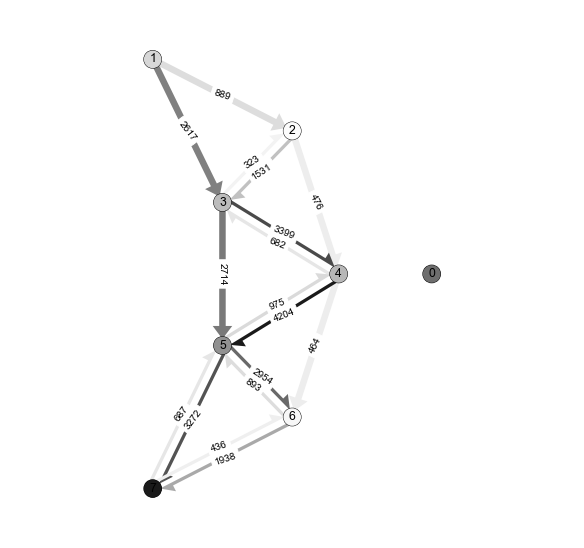

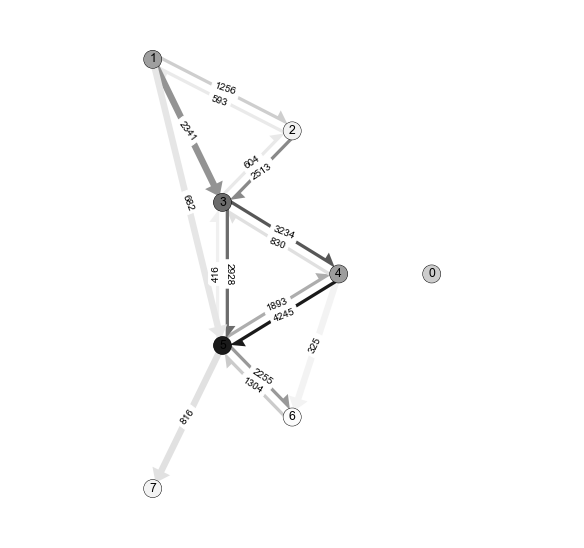

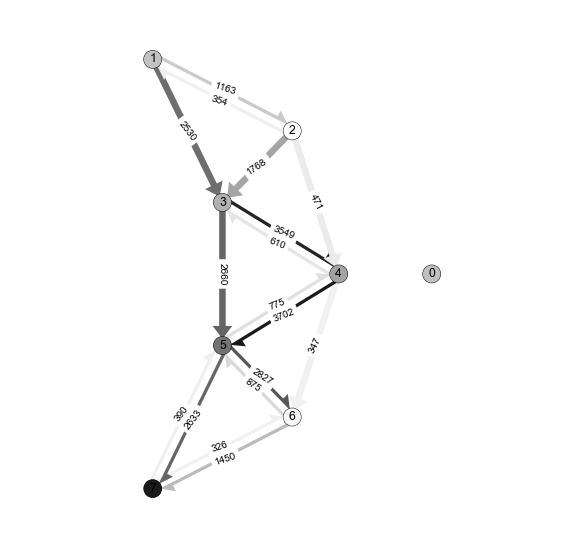

In [404]:
for tind, trial in enumerate(trialName):
    
    transSpace = transSpaces[tind]
    transCount = transCounts[tind]
    
    nodeNames = set([n1 for n1, n2 in transSpace] + [n2 for n1, n2 in transSpace])
    
    shape = (max(nodeNames)+1, max(nodeNames)+1)
    edgeArray = np.asarray(transSpace)

    coo = sparse.coo_matrix((transCount, (edgeArray[:, 0], edgeArray[:, 1])), shape=shape,
                            dtype=edgeArray.dtype)

    connectivityMatrix = np.asarray(coo.todense())
    print(connectivityMatrix)


    fig, ax = plt.subplots(1,1, figsize=(10,10))

    countCutoff = 300  #50 for all, 5 for single fly

    graph = connectivityMatrix/1.

    graphOffDig = graph.copy()

    node_count = np.zeros(shape[0])
    for i in range(shape[0]):
        node_count[i] = graph[i,i]
        graphOffDig[i,i] = 0

    for i in range(shape[0]):
        for j in range(shape[0]):
            if graphOffDig[i,j] <= countCutoff:
                graphOffDig[i,j] = 0

    normGraph = graphOffDig/np.max(graphOffDig)

    sc = 1.3
    node_positions = {0 : (3.5, 4/sc), 1 : (0.5, 7/sc), 2 : (2, 6/sc), 3 : (1.25, 5/sc), \
                      4 : (2.5, 4/sc), 5 : (1.25, 3/sc), 6 : (2, 2/sc), 7 : (0.5, 1/sc)}

    node_names = {0 : '0', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6', 7 : '7'}

    #mylabels = dict([((edgeArray[i,0],edgeArray[i,1],),int(transCount[i])) for i in range(len(edgeArray))])
    mylabels = dict([((edgeArray[transCount > countCutoff,:][i,0],
                       edgeArray[transCount > countCutoff,:][i,1],),int(transCount[transCount > countCutoff][i])) 
                     for i in range(len(edgeArray[transCount > countCutoff,:]))])
    # generate node color map
    cNorm  = colors.Normalize(vmin=0, vmax=np.max(node_count))
    nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Reds')

    # plot
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        netgraph.draw(normGraph,node_positions, node_size=7, ax=ax, node_labels=node_names,\
                      edge_width=7,edge_cmap='RdGy',edge_labels=mylabels)
    ax.set_ylim(0.5/sc,7.5/sc)
    ax.set_xlim(-1,5)
    ax.axis('off')
    
    # color nodes according to count
    # generate node color map
    numNodes = len(node_names)
    cNorm  = colors.Normalize(vmin=-np.max(abs(node_count)), vmax=np.max(abs(node_count)))
    nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='RdGy')

    i = 0
    for key, values in node_positions.items():
        node_to_artist = netgraph.draw_nodes({key : values}, node_color=nodeCMap.to_rgba(node_count[i]),\
                                             ax=ax, node_size=10)
        i = i+1
        
    fig.savefig(analysisDir + groupName +'_cutoff'+str(countCutoff)+'_dt'+str(dt)+'_'+ trial+'_'+angleMask+'.pdf', format='pdf')

In [405]:
connectivityMatrixes = np.zeros((len(trialName),len(nodeNames),len(nodeNames)))
edgeArrays = []
for tind, trial in enumerate(trialName):
    
    transSpace = transSpaces[tind]
    transCount = transCounts[tind]
    
    #nodeNames = set([n1 for n1, n2 in transSpace] + [n2 for n1, n2 in transSpace])
    
    shape = (max(nodeNames)+1, max(nodeNames)+1)
    edgeArray = np.asarray(transSpace)

    coo = sparse.coo_matrix((transCount, (edgeArray[:, 0], edgeArray[:, 1])), shape=shape,
                            dtype=edgeArray.dtype)

    connectivityMatrix = np.asarray(coo.todense())
    connectivityMatrixes[tind,:,:] = connectivityMatrix
    edgeArrays.append(edgeArray)

[[   0.    0.    0.  -72. -146.    0.    0.    0.]
 [   0.    0.  274.  -87.    0.   60.    0.    0.]
 [   0.  169.    0.  237.    0.    0.    0.    0.]
 [ -68.    0.    0.    0.  150.  -54.    0.    0.]
 [-152.    0.    0.  -72.    0. -502. -117.    0.]
 [   0.    0.    0.    0. -200.    0. -127. -639.]
 [   0.    0.    0.    0.    0.    0.    0. -488.]
 [   0.    0.    0.    0.    0. -297. -110.    0.]]


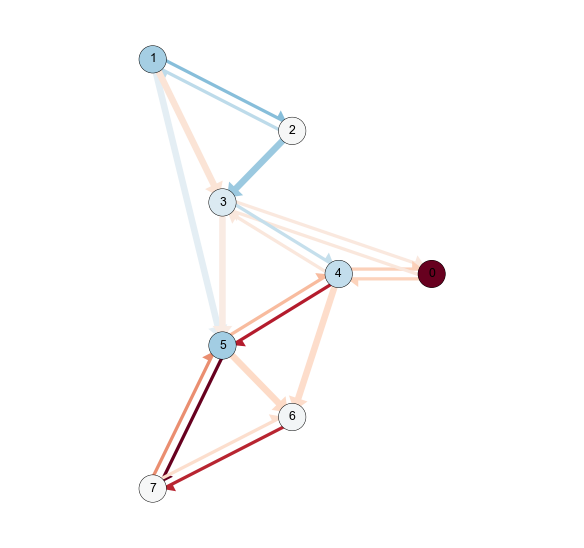

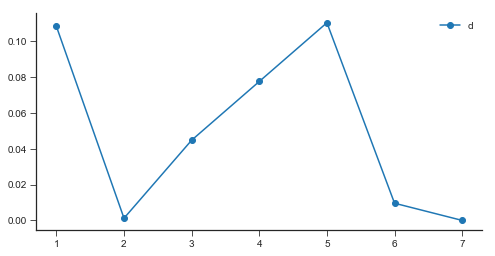

In [406]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

m1 = connectivityMatrixes[2,:,:].copy()
m2 = connectivityMatrixes[0,:,:].copy()

node_count = np.zeros(shape[0])
for i in range(shape[0]):
    node_count[i] = m1[i,i]/np.max(connectivityMatrixes[2,:,:])-m2[i,i]/np.max(connectivityMatrixes[0,:,:])
    
for i in range(shape[0]):
    m1[i,i] = 0
    m2[i,i] = 0
    
graphOffDig =  m1-m2#m1/np.max(m1) - m2/np.max(m2)

countCutoff = 50#5

for i in range(shape[0]):
    for j in range(shape[0]):
        if abs(graphOffDig[i,j]) <= countCutoff:
            graphOffDig[i,j] = 0

sc = 1.3
node_positions = {0 : (3.5, 4/sc), 1 : (0.5, 7/sc), 2 : (2, 6/sc), 3 : (1.25, 5/sc), \
                  4 : (2.5, 4/sc), 5 : (1.25, 3/sc), 6 : (2, 2/sc), 7 : (0.5, 1/sc)}

node_names = {0 : '0', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6', 7 : '7'}

#mylabels = dict([((edgeArray[i,0],edgeArray[i,1],),int(transCount[i])) for i in range(len(edgeArray))])

# generate node color map
cNorm  = colors.Normalize(vmin=0, vmax=np.max(node_count))
nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Reds')

# plot
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    netgraph.draw(graphOffDig,node_positions, node_size=7, ax=ax, node_labels=node_names,\
                  edge_width=7,edge_cmap='RdBu')#,edge_labels=mylabels)
ax.set_ylim(0.5/sc,7.5/sc)
ax.set_xlim(-1,5)
ax.axis('off');

# color nodes according to count
# generate node color map
numNodes = len(node_names)
cNorm  = colors.Normalize(vmin=-np.max(abs(node_count)), vmax=np.max(abs(node_count)))
nodeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='RdBu')

i = 0
for key, values in node_positions.items():
    node_to_artist = netgraph.draw_nodes({key : values}, node_color=nodeCMap.to_rgba(node_count[i]),\
                                         ax=ax, node_size=15)
    i = i+1
    
fig.savefig(analysisDir + groupName +'_prePostDiff_cutoff'+str(countCutoff)+'_dt'+str(dt)+'_'+angleMask+'.pdf', format='pdf')

print(graphOffDig.astype('float'))

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(list(nodeNames)[1:],node_count.T[1:],'-o')
ax.legend('diff')
myAxisTheme(ax)
fig.savefig(analysisDir + groupName +'_prePostDiffStatecount_dt'+str(dt)+'_'+angleMask+'.pdf', format='pdf')